https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

http://gluon.mxnet.io/chapter14_generative-adversarial-networks/gan-intro.html

https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/406_GAN.ipynb

## Objective: Fit 1D Array Data Using GAN with Gluon

![Picture description](images/gan_simple-gan.png)

In [1]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
import numpy as np

ctx = mx.gpu()

In [2]:
%matplotlib inline

#### Getting the real Data

In [3]:
import pandas as pd

In [4]:
###### Hyper Parameters
BATCH_SIZE = 64
ART_COMPONENTS = 5     # it could be total point G can draw in the canvas
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])

In [5]:
import numpy as np
import matplotlib.pyplot as plt

##### upper bound와 lower bound 사이의 샘플을 뽑는 것이 목표

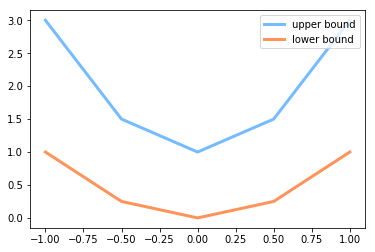

In [6]:
# show our beautiful painting range
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [7]:
np.random.seed(1)
def artist_works(sample_n = 100):     # painting from the famous artist (real target)
    a = np.random.uniform(1, 2, size=sample_n)[:, np.newaxis]
    paintings = a * np.power(np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(sample_n)]), 2) + (a-1)
    return np.array(paintings)

##### True Example

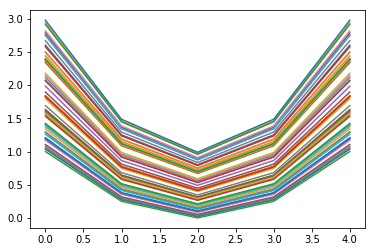

In [8]:
artist_paintings = artist_works(sample_n = 1000)
pd.DataFrame(np.transpose(artist_paintings[0:BATCH_SIZE])).plot(legend=False)
train_data = mx.io.NDArrayIter(data=artist_paintings, label=None, batch_size=BATCH_SIZE, shuffle=True)

### Define the Network

In [9]:
# build the generator
class netGenerator(gluon.HybridBlock):
    def __init__(self,**kwargs):
        super(netGenerator,self).__init__(**kwargs)
        with self.name_scope():
            self.dense0 = nn.Dense(ART_COMPONENTS)
                                   
    def forward(self,x,view=False):
        self.view = view
        x = self.dense0(x)
        if self.view :
            print("1st dense0 output shape:{s}".format(s=x.shape))
                       
        return x

In [10]:
# build the generator
class netDiscremeter(gluon.HybridBlock):
    def __init__(self,**kwargs):
        super(netDiscremeter,self).__init__(**kwargs)
        with self.name_scope():
            self.dense0 = nn.Dense(10, activation='relu')
            self.dense1 = nn.Dense(5, activation='relu')
            self.dense2 = nn.Dense(ART_COMPONENTS)

                                   
    def forward(self,x,view=False):
        self.view = view
        x = self.dense0(x)
        if self.view :
            print("1st dense0 output shape:{s}".format(s=x.shape))
            
        x = self.dense1(x)
        if self.view :
            print("1st dense0 output shape:{s}".format(s=x.shape))
            
        x = self.dense2(x)
        if self.view :
            print("1st dense0 output shape:{s}".format(s=x.shape))
           
        return x

In [11]:
lr = 0.005

In [12]:
netG = netGenerator()
netD = netDiscremeter()
# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr})

In [13]:
real_label = mx.nd.ones((BATCH_SIZE,), ctx=ctx)
fake_label = mx.nd.zeros((BATCH_SIZE,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time

\begin{equation*}
\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))] \hspace{15pt}  (1)
\end{equation*}

![Picture description](images/gan_nips2014_.png)

In [14]:
def drawGraph(generate_num = 10):
    
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ## fig1
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('data generating distribution')
    ax.set_ylim(0, 3)
    for i in range(len(data)):
        ax.plot(PAINT_POINTS[0], data.asnumpy()[i])
        
    ## fig2
    # G(Z)
    noise = nd.random_normal(shape=(generate_num, ART_COMPONENTS), ctx=ctx)
    sam_fake = netG(noise).asnumpy()
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('generative distribution G(Z)')
    ax.set_ylim(0, 3)
    for i in range(len(sam_fake)):
        ax.plot(PAINT_POINTS[0], sam_fake[i])
    
    ax.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
    ax.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
    
    ## fig3
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('D*(X)')
    #ax.set_ylim(0, 1)
    
    output_d = (real_output) /  (real_output + fake_output)
    
    for i in range(len(output_d)):
        ax.plot(PAINT_POINTS[0], output_d.asnumpy()[i])
    
    plt.show()

In practice, equation 1 may not provide sufficient gradient for G to learn well. Early in learning,
when G is poor, D can reject samples with high confidence because they are clearly different from
the training data. In this case, log(1 − D(G(z))) saturates. Rather than training G to minimize
log(1 − D(G(z))) we can train G to maximize log D(G(z)). This objective function results in the
same fixed point of the dynamics of G and D but provides much stronger gradients early in learning.

\begin{equation*}
arg\min_G log(1-D(G(z))) >> arg\max_G log(D(G(z))) 
\end{equation*}


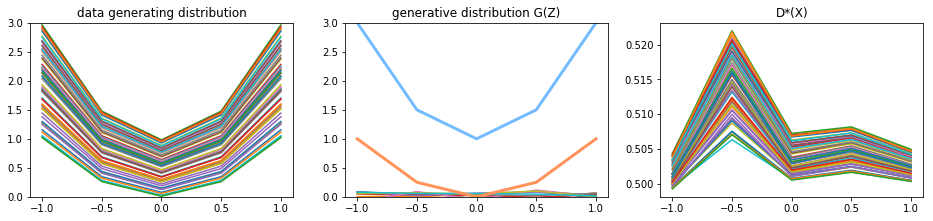


binary training acc at epoch 0: accuracy=0.694010
time: 0.338400


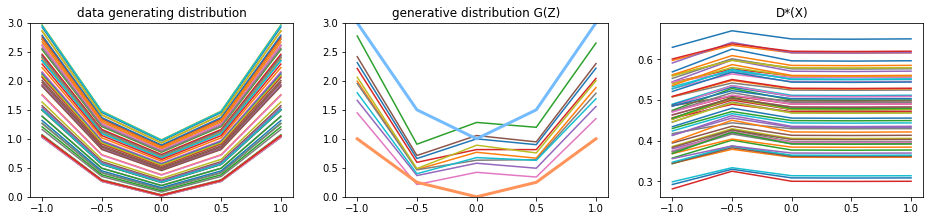


binary training acc at epoch 500: accuracy=0.598587
time: 0.306314


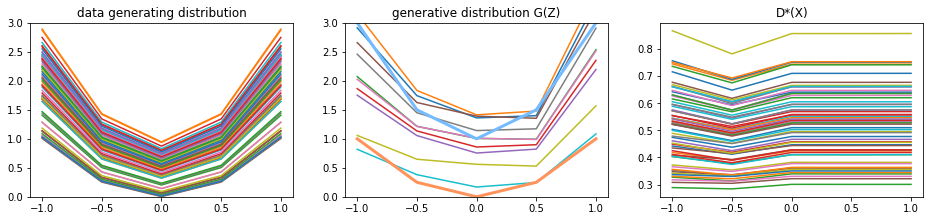


binary training acc at epoch 1000: accuracy=0.602968
time: 0.326869


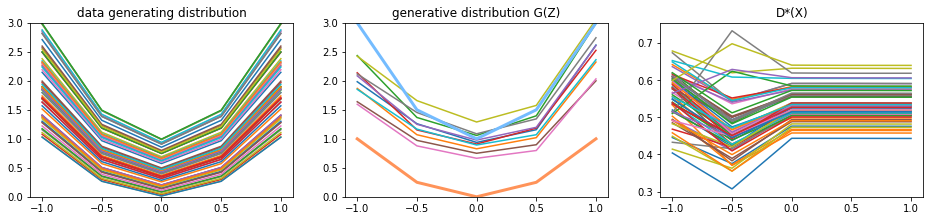


binary training acc at epoch 1500: accuracy=0.588523
time: 0.296288


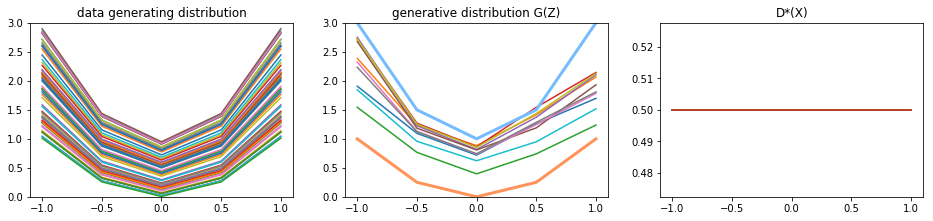


binary training acc at epoch 2000: accuracy=0.536141
time: 0.316341


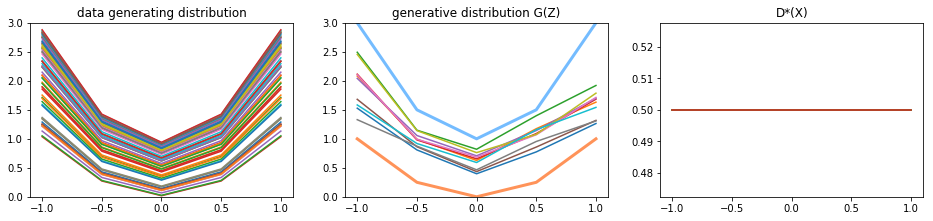


binary training acc at epoch 2500: accuracy=0.500002
time: 0.320352


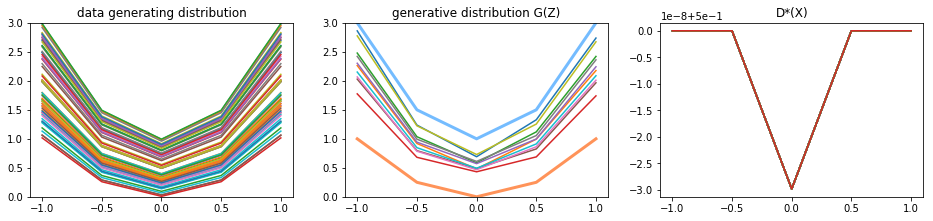


binary training acc at epoch 3000: accuracy=0.507465
time: 0.348928


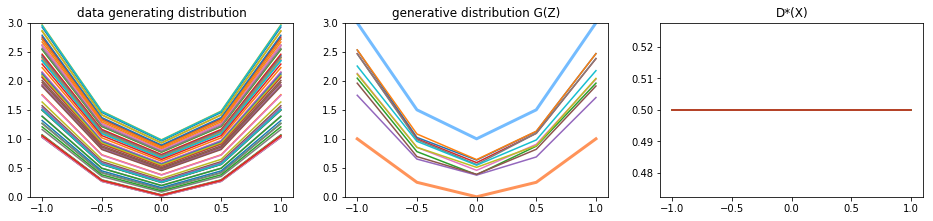


binary training acc at epoch 3500: accuracy=0.500000
time: 0.302304


In [15]:
stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
for epoch in range(4000):
    #print (epoch)
    tic = time.time()
    train_data.reset()
    show_random_num = np.random.randint(0,10)
    for idx, batch in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real_t
        data = batch.data[0].as_in_context(ctx)
        noise = nd.random_normal(shape=(BATCH_SIZE,ART_COMPONENTS), ctx=ctx)
        
        with autograd.record():
            real_output = netD(data)
            errD_real = loss(real_output, real_label)
            metric.update([real_label,], [real_output,])

            fake = netG(noise)
            fake_output = netD(fake.detach())
            errD_fake = loss(fake_output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [fake_output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            output = netD(fake)
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])
        #print (epoch, idx, show_random_num)
        if (epoch % 500 == 0) & (idx == show_random_num):
            name, acc = metric.get()
            metric.reset()
                
            drawGraph()
        
            print('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
            print('time: %f' % (time.time() - tic))